In [482]:
from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Union, Tuple

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [763]:
class AmmortizationSchedule:

    def __init__(self, n: int, debt: float, rate: float) -> None:
        """
        Args:
            n (int): Number of periods (total number of payments).
            debt (float): Present value or principal (loan amount).
            rate (float): Interest rate per period (e.g., monthly interest rate).
        """

        self.n = n
        self.debt = debt
        self.rate = rate
        self.payment = self._calculate_payment(n=self.n, debt=self.debt, rate=self.rate)

        self.schedule: pd.DataFrame = self._calculate_ammortization_schedule() 

        return
    
    @staticmethod
    def _calculate_interest(debt: float, rate: float) -> float:
        return debt * rate
    
    @staticmethod
    def _calculate_principal(payment: float, interest: float) -> float:
        return payment - interest
    
    @staticmethod
    def _calculate_debt(debt: float, principal: float) -> float:
        return debt - principal
    
    @staticmethod
    def _calculate_equity(equity: float, principal: float) -> float:
        return equity + principal
    
    @staticmethod
    def _calculate_payment(n: int, debt: float, rate: float) -> float:
        """
        Computes the periodic payment that accounts for principal, interest, and compunding.
        """

        if rate == 0.0:
            
            # If zero interest rate, return equally divied payments of the outstanding debt
            return debt / n
        
        else:

            # Scale periodic interest on outstanding debt by a discount rate that accounts for compounding  
            return (debt * rate) / (1 - 1 / (1 + rate) ** n)
    
    def _calculate_ammortization_schedule(self) -> pd.DataFrame:
        
        equity: float = 0.0
        debt: float = self.debt
        
        schedule: Dict[int, Dict[str, float]] = {}

        for t in range(self.n):

            schedule[t] = {}
            
            schedule[t]["payment"] = self.payment
            schedule[t]["interest"] = self._calculate_interest(rate=self.rate, debt=debt)
            schedule[t]["principal"] = self._calculate_principal(payment=self.payment, interest=schedule[t]["interest"]) 

            debt = self._calculate_debt(debt=debt, principal=schedule[t]["principal"])
            equity = self._calculate_equity(equity=equity, principal=schedule[t]["principal"])
            
            schedule[t]["debt"] = debt
            schedule[t]["equity"] = equity

        return pd.DataFrame(schedule).T 

    def plot(self) -> None:
        
        self.schedule[["debt", "equity"]].plot(title="Debt vs. Equity Schedule")      
        self.schedule[["interest", "principal", "payment"]].plot(title="Ammortization Schedule")
        
        return


class RandomVariable(ABC):

    @abstractmethod
    def simulate(self) -> float:
        """
        Simulates a variable.
        """
        raise NotImplementedError


class NormalRandomVariable(RandomVariable):

    def __init__(self, mu: float, sigma: Optional[float] = None) -> None:

        self.mu = mu
        self.sigma = sigma

        return

    def simulate(self) -> float:
        """
        Simulates a normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """
        return np.random.normal(loc=self.mu, scale=self.sigma) if self.sigma else self.mu


class LogNormalRandomVariable:

    def __init__(self, mu: float, sigma: Optional[float] = None) -> None:

        self.mu = mu
        self.sigma = sigma

        return

    def simulate(self) -> float:
        """
        Simulates a log-normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """
        return np.exp(np.random.normal(loc=self.mu - 0.5 * self.sigma ** 2, scale=self.sigma)) - 1 if self.sigma else self.mu


class BoundedNormalRandomVariable(RandomVariable):

    def __init__(self, mu: float, sigma: float, lower_bound: float, upper_bound: float) -> None:

        self.mu = mu
        self.sigma = sigma
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        return

    def simulate(self) -> float:
        """
        Simulates a bounded normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """

        x = np.random.normal(loc=self.mu, scale=self.sigma)

        return x if self.lower_bound <= x <= self.upper_bound else self.simulate()


class UniformRandomVariable(RandomVariable):

    def __init__(self, lower_bound: float, upper_bound: float) -> None:

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        return

    def simulate(self) -> float:
        """
        Simulates a uniformly distributed variable.
        """
        return np.random.uniform(low=self.lower_bound, high=self.upper_bound)


class IndicatorRandomVariable(RandomVariable):

    def __init__(self, probability: float) -> None:

        self.probability = probability

        return

    def simulate(self) -> float:
        """
        Simulates an indicator random variables for a given probability.
        """
        return np.random.choice(a=[0, 1], p=[1 - self.probability, self.probability])


class RevenueModel:

    def __call__(self, rent: float, occupancy_rate: float) -> float:
        """
        TODO: create time varying paths of rents, occupancy_rate, etc.

        Args:
            rent (float): Expected monthly rent.
            occupancy_rate (float): Expected occupancy rate as a fraction.
        """
        return rent * occupancy_rate 


class TaxBenefitModel:

    def __call__(self, n: int, interest_expense: float, property_value: float) -> float:
        """
        TODO: determine the true calculation - this is a rough proxy for now.
        """

        uncertainty_discount_factor = 0.5
        depreciation_deduction = property_value / n
        interest_deduction = interest_expense * 0.3
        property_tax_deduction = min(10_000, property_value * 0.02 / 12)
        
        return 0   # interest_deduction + depreciation_deduction * uncertainty_discount_factor + property_tax_deduction


class ExpenseModel:

    def __call__(
            self,  
            utility_expense: float, 
            interest_expense: float,
            insurance_expense: float,
            maintenance_expense: float,
            property_tax_expense: float,
            miscellaneous_expense: float
    ) -> float:
                
        return (
            utility_expense +
            interest_expense + 
            insurance_expense + 
            maintenance_expense + 
            property_tax_expense + 
            miscellaneous_expense
        )


class MonteCarloSimulator:

    def __init__(
            self,
            n: int,
            debt: float,
            rate: float,
            rent: float,
            equity: float,
            n_simulations: int,
            expense_model: ExpenseModel,
            revenue_model: RevenueModel,
            tax_benefit_model: TaxBenefitModel,
            occupancy_rate: RandomVariable,
            utility_expense: RandomVariable,
            insurance_expense: RandomVariable,
            maintenance_expense: RandomVariable,
            property_tax_expense: RandomVariable,
            miscellaneous_expense: RandomVariable
    ) -> None:
        
        self.n = n
        self.debt = debt
        self.rate = rate
        self.rent = rent
        self.equity = equity
        self.n_simulations = n_simulations
        self.expense_model = expense_model
        self.revenue_model = revenue_model
        self.tax_benefit_model = tax_benefit_model
        self.occupancy_rate = occupancy_rate        
        self.utility_expense = utility_expense
        self.insurance_expense = insurance_expense
        self.maintenance_expense = maintenance_expense
        self.property_tax_expense = property_tax_expense
        self.miscellaneous_expense = miscellaneous_expense

        self.property_value = self.debt + self.equity
        self.ammortization_schedule = AmmortizationSchedule(n=self.n, debt=self.debt, rate=self.rate)

        self.revenue_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.expense_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.cash_flow_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.tax_benefit_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        
        return
    
    def _simulate(self, t: int) -> Tuple[float, float, float]:

        interest_expense: float = self.ammortization_schedule.schedule.loc[t, "interest"]

        revenue: float = self.revenue_model(rent=self.rent, occupancy_rate=self.occupancy_rate.simulate())

        tax_benefit: float = self.tax_benefit_model(n=self.n, interest_expense=interest_expense, property_value=self.property_value)
        
        expenses: float = self.expense_model(
            interest_expense=interest_expense,
            utility_expense=self.utility_expense.simulate(),
            insurance_expense=self.insurance_expense.simulate(), 
            maintenance_expense=self.maintenance_expense.simulate(),
            property_tax_expense=self.property_tax_expense.simulate(),
            miscellaneous_expense=self.miscellaneous_expense.simulate()
        )

        cash_flow: float = revenue + tax_benefit - expenses

        return revenue, tax_benefit, expenses, cash_flow

    def run(self) -> pd.DataFrame:

        self.revenue_simulation = np.empty(shape=(self.n, self.n_simulations))
        self.expense_simulation = np.empty(shape=(self.n, self.n_simulations))
        self.cash_flow_simulation = np.empty(shape=(self.n, self.n_simulations))
        self.tax_benefit_simulation = np.empty(shape=(self.n, self.n_simulations))

        for t in range(self.n):
            for n in range(self.n_simulations):
                self.revenue_simulation[t, n], self.tax_benefit_simulation[t, n], self.expense_simulation[t, n], self.cash_flow_simulation[t, n] = self._simulate(t=t)

        self.revenue_simulation = pd.DataFrame(self.revenue_simulation)
        self.expense_simulation = pd.DataFrame(self.expense_simulation)
        self.cash_flow_simulation = pd.DataFrame(self.cash_flow_simulation) 
        self.tax_benefit_simulation = pd.DataFrame(self.tax_benefit_simulation)
        
        return
    
    def analyze(self) -> None:
        """
        Analyze the results of the Monte Carlo simulation, such as expected profit/loss.
        """

        if self.cash_flow_simulation is None:
            self.run()
            
        cumulative_cash_flows = self.cash_flow_simulation.sum(axis=0)
        
        print(f"Mean Cash Flow: {cumulative_cash_flows.mean()}")
        print(f"Min Cash Flow: {cumulative_cash_flows.min()}")
        print(f"Max Cash Flow: {cumulative_cash_flows.max()}")

        self.cash_flow_simulation.plot(title="Periodic Cash Flows", legend=False)
        self.cash_flow_simulation.plot(kind="hist", title="Periodic Cash Flows", legend=False)
        self.cash_flow_simulation.cumsum().plot(title="Cumulative Cash Flows", legend=False)

        self.revenue_simulation.plot(title="Periodic Revenue", legend=False)
        self.expense_simulation.plot(title="Periodic Expenses", legend=False)
        self.tax_benefit_simulation.plot(title="Periodic Tax Benefit", legend=False)

        return

In [772]:
N_SIMULATIONS: int = 1_000
N_PAYMENTS_PER_PERIOD: int = 12 
N: int = 30 * N_PAYMENTS_PER_PERIOD
RATE: float = 0.065 / N_PAYMENTS_PER_PERIOD

RENT: float = 3_500.0
DEBT: float = 325_000.0
EQUITY: float = 100_000.0

EXPENSE_MODEL: ExpenseModel = ExpenseModel()
REVENUE_MODEL: RevenueModel = RevenueModel()
TAX_BENEFIT_MODEL: TaxBenefitModel = TaxBenefitModel()

PERCENT_TAX_EXPENSE: float = 0.02 / N_PAYMENTS_PER_PERIOD
TAX_EXPENSE_MU: float = PERCENT_TAX_EXPENSE * (DEBT + EQUITY)
TAX_EXPENSE: RandomVariable = NormalRandomVariable(mu=TAX_EXPENSE_MU) 

OCCUPANCY_RATE_PROBABILITY: float = 0.9
OCCUPANCY_RATE: RandomVariable = IndicatorRandomVariable(probability=OCCUPANCY_RATE_PROBABILITY)

UTILITY_EXPENSE_MU: float = 100.0
UTILITY_EXPENSE_SIGMA: float = 20.0
UTILITY_EXPENSE_LOWER_BOUND: float = 50.0
UTILITY_EXPENSE_UPPER_BOUND: float = 200.0
UTILITY_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=UTILITY_EXPENSE_MU, sigma=UTILITY_EXPENSE_SIGMA, lower_bound=UTILITY_EXPENSE_LOWER_BOUND, upper_bound=UTILITY_EXPENSE_UPPER_BOUND)

INSURACE_EXPENSE_MU: float = 100.0
INSURACE_EXPENSE_SIGMA: float = 20.0
INSURANCE_EXPENSE_LOWER_BOUND: float = 20.0
INSURANCE_EXPENSE_UPPER_BOUND: float = 200.0
INSURACE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=INSURACE_EXPENSE_MU, sigma=INSURACE_EXPENSE_SIGMA, lower_bound=INSURANCE_EXPENSE_LOWER_BOUND, upper_bound=INSURANCE_EXPENSE_UPPER_BOUND)

MAINTENANCE_EXPENSE_MU: float = 100.0
MAINTENANCE_EXPENSE_SIGMA: float = 20.0
MAINTENANCE_EXPENSE_LOWER_BOUND: float = 20.0
MAINTENANCE_EXPENSE_UPPER_BOUND: float = 200.0
MAINTENANCE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=MAINTENANCE_EXPENSE_MU, sigma=MAINTENANCE_EXPENSE_SIGMA, lower_bound=MAINTENANCE_EXPENSE_LOWER_BOUND, upper_bound=MAINTENANCE_EXPENSE_UPPER_BOUND)

MISCELLANEOUS_EXPENSE_MU: float = 500.0
MISCELLANEOUS_EXPENSE_SIGMA: Optional[float] = 250.0
MISCELLANEOUS_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=MISCELLANEOUS_EXPENSE_MU, sigma=MISCELLANEOUS_EXPENSE_SIGMA, lower_bound=0.0, upper_bound=2000.0)

In [773]:
simulation = MonteCarloSimulator(
    n=N,
    debt=DEBT,
    rate=RATE,      
    rent=RENT, 
    equity=EQUITY,
    expense_model=EXPENSE_MODEL,
    revenue_model=REVENUE_MODEL,
    tax_benefit_model=TAX_BENEFIT_MODEL,
    n_simulations=N_SIMULATIONS, 
    property_tax_expense=TAX_EXPENSE,
    occupancy_rate=OCCUPANCY_RATE,      
    utility_expense=UTILITY_EXPENSE, 
    insurance_expense=INSURACE_EXPENSE,
    maintenance_expense=MAINTENANCE_EXPENSE,
    miscellaneous_expense=MISCELLANEOUS_EXPENSE
)

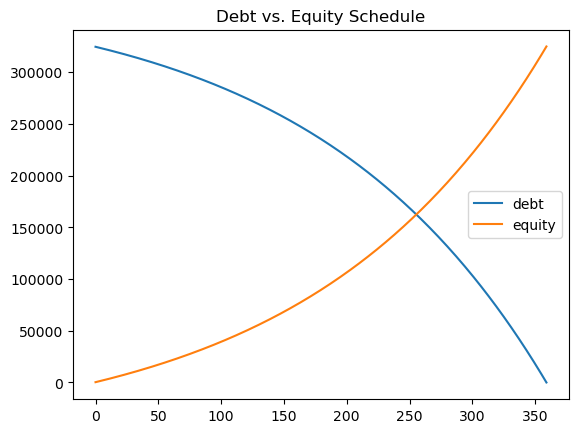

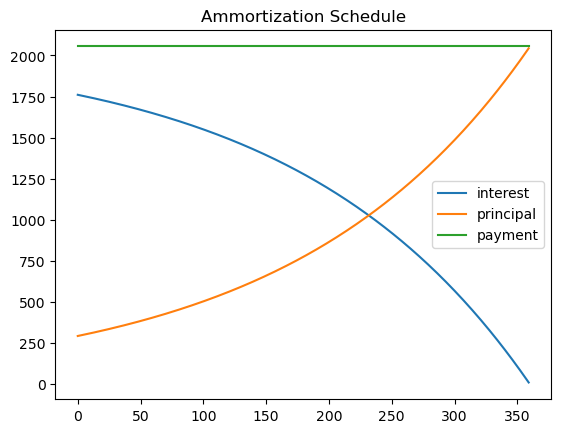

In [767]:
simulation.ammortization_schedule.plot()

<Axes: >

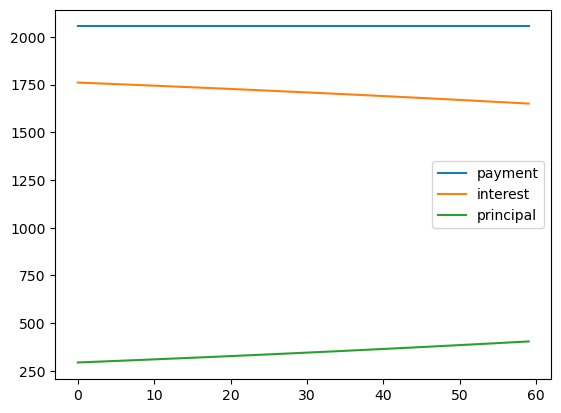

In [768]:
simulation.ammortization_schedule.schedule.head(12*5).iloc[:, :3].plot()

Mean Cash Flow: 172164.24468516564
Min Cash Flow: 85217.55451244334
Max Cash Flow: 235312.38570697026


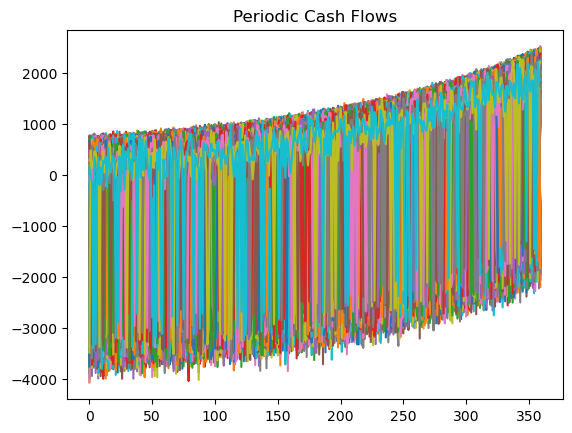

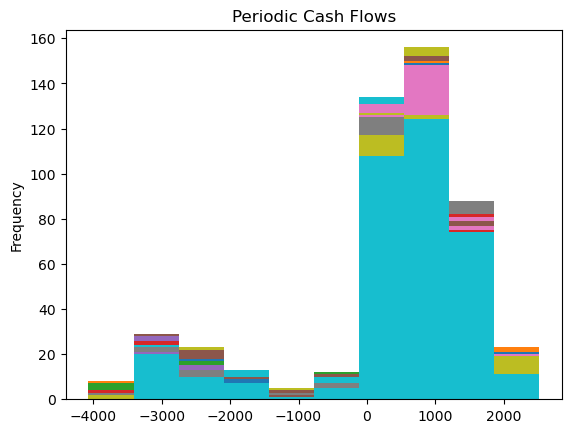

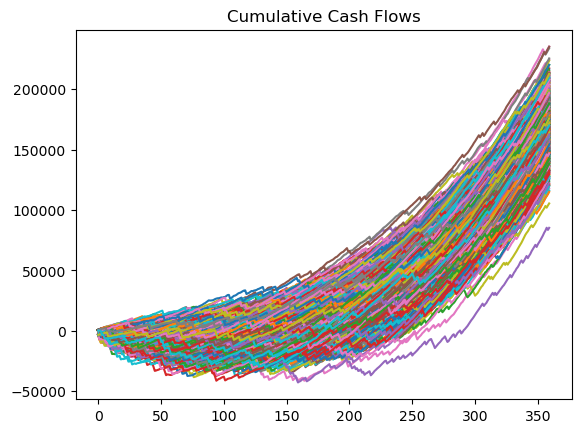

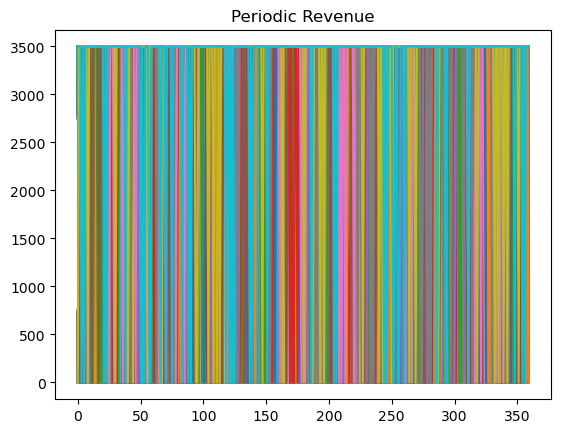

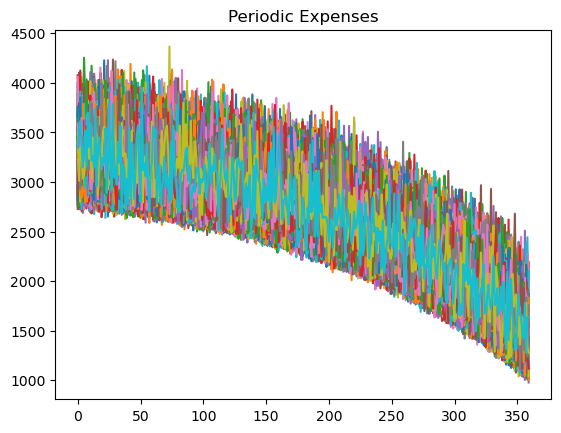

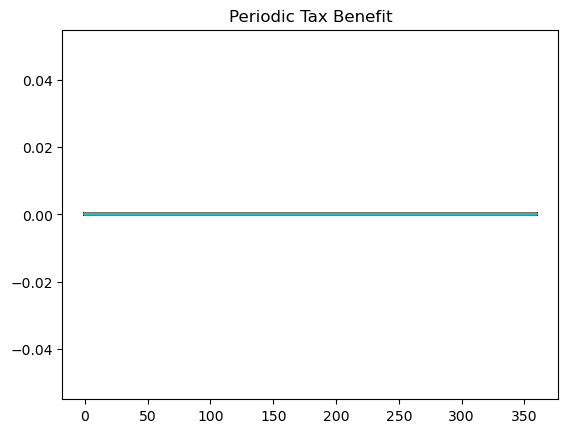

In [774]:
simulation.analyze()